In [236]:
import tensorflow as tf
print(tf.__version__)

2.9.1


In [237]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import numpy as np

In [238]:

TRAIN_DIR = './data/train/'
VAL_DIR = './data/val/'
IMG_WIDTH = 224
IMG_HEIGHT = 224
NUM_CLASSES = 2
BATCH_SIZE = 32

# create the generators
def get_train_generator():
    train_data = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    rotation_range=20, 
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True)
    
    train_generator = train_data.flow_from_directory(directory=TRAIN_DIR,
                                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                classes=None, # infer classes from directory
                                                class_mode='categorical',
                                                batch_size=BATCH_SIZE,
                                                seed=1234)
    
    return train_generator



def get_val_generator(batch_size=BATCH_SIZE):
    val_data = ImageDataGenerator(preprocessing_function=preprocess_input)
    
    val_generator = val_data.flow_from_directory(directory=VAL_DIR,
                                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                classes=None,
                                                class_mode='categorical',
                                                shuffle=False,
                                                batch_size=batch_size)
    
    return val_generator

In [239]:
train_generator = get_train_generator()
                        
val_generator = get_val_generator()

Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [240]:
def get_model():
    
    # load the MobileNet model without the top layer
    base_model = MobileNet(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), include_top=False)

    # freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    inputs = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    lyr = base_model(inputs)
    lyr = GlobalAveragePooling2D()(lyr)
    lyr = Dense(64, activation='relu')(lyr)
    lyr = Dropout(0.5)(lyr)
    outputs = Dense(NUM_CLASSES, activation='softmax')(lyr)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model
    

In [241]:
# get the model and print the summary
model = get_model()
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_6   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 64)                65600     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 2)                 130 

In [242]:
NUM_SAMPLES = 500
num_steps = NUM_SAMPLES / BATCH_SIZE

history = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=num_steps,
                   epochs=15, 
                   steps_per_epoch=num_steps)

/var/folders/_n/2ny489c138xb06v1_8d_vp240000gn/T/ipykernel_22106/340121028.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=num_steps,


Epoch 1/15
15/15 [==============================] - 35s 2s/step - loss: 0.6607 - accuracy: 0.7020 - val_loss: 0.2163 - val_accuracy: 0.9320
Epoch 2/15
15/15 [==============================] - 37s 2s/step - loss: 0.3242 - accuracy: 0.8660 - val_loss: 0.1639 - val_accuracy: 0.9420
Epoch 3/15
15/15 [==============================] - 45s 3s/step - loss: 0.2434 - accuracy: 0.9080 - val_loss: 0.1229 - val_accuracy: 0.9520
Epoch 4/15
15/15 [==============================] - 63s 4s/step - loss: 0.2416 - accuracy: 0.8980 - val_loss: 0.1107 - val_accuracy: 0.9600
Epoch 5/15
15/15 [==============================] - 42s 3s/step - loss: 0.2043 - accuracy: 0.9220 - val_loss: 0.1097 - val_accuracy: 0.9580
Epoch 6/15
15/15 [==============================] - 35s 2s/step - loss: 0.1943 - accuracy: 0.9300 - val_loss: 0.1353 - val_accuracy: 0.9460
Epoch 7/15
15/15 [==============================] - 34s 2s/step - loss: 0.2018 - accuracy: 0.9260 - val_loss: 0.1054 - val_accuracy: 0.9560
Epoch 8/15
15/15 [==

In [243]:
# model.save('model.h5')
from tensorflow.keras.models import load_model

model = load_model('model.h5')

In [244]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 0, 'Epoch')

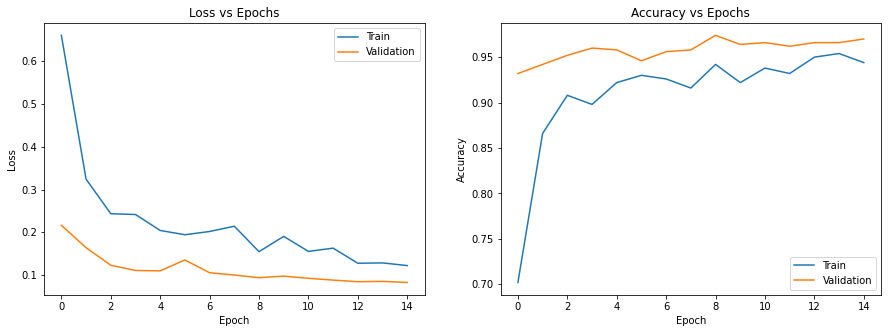

In [245]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,5))

fig.add_subplot(121)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss vs Epochs')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')

fig.add_subplot(122)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

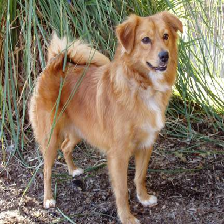

In [246]:
from tensorflow.keras.preprocessing import image

img_path = './data/dog.10003.jpg'
img = image.load_img(img_path, target_size=(IMG_WIDTH,IMG_HEIGHT))
img

In [247]:
print(type(img))
img_array = image.img_to_array(img) # adds channels to the img
print(type(img_array))
print(img_array.ndim)
print(img_array.shape)
img_array = img_array[np.newaxis, ...] # add dimension at the beginning
print(img_array.shape)

<class 'PIL.Image.Image'>
<class 'numpy.ndarray'>
3
(224, 224, 3)
(1, 224, 224, 3)


In [248]:
# get the prediction for the new image
img_preprocessed = preprocess_input(img_array)
prediction = model.predict(img_preprocessed)
print(prediction)

1/1 [==============================] - 0s 462ms/step
[[8.054002e-05 9.999194e-01]]


In [249]:
print(np.round(prediction, 3))
print(val_generator.class_indices)

[[0. 1.]]
{'cat': 0, 'dog': 1}


In [250]:
predictions = model.predict(val_generator)

16/16 [==============================] - 15s 874ms/step


In [251]:
print(type(predictions))
print(predictions.shape)

<class 'numpy.ndarray'>
(500, 2)


In [252]:
def get_img_generator():
    img_data = ImageDataGenerator()
    
    img_generator = img_data.flow_from_directory(directory=VAL_DIR,
                                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                classes=None,
                                                class_mode='categorical',
                                                shuffle=False,
                                                batch_size=1)
    
    return img_generator

Found 500 images belonging to 2 classes.


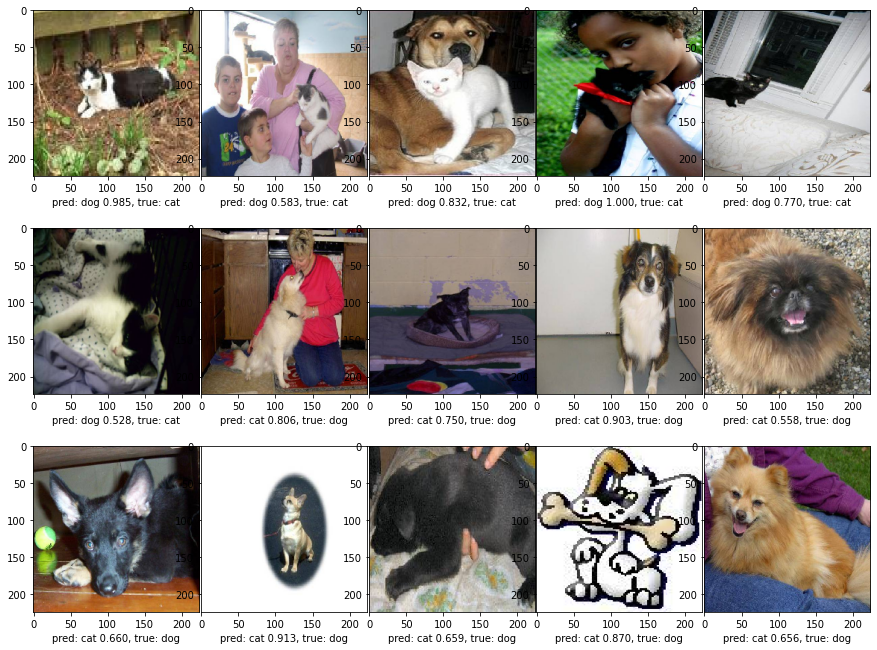

In [253]:
# show plot of wrong predictions with their values
plt.figure(figsize=(15, 20))
n = 0

val_generator = get_img_generator()
# val_generator = get_val_generator(batch_size=1)
pred_dict = {}
for index, pred in enumerate(predictions):
    predicted_label = np.argmax(pred)
    true_label = val_generator.classes[index]
    val = pred[predicted_label]
    pred_dict[index] = {'predicted_label': predicted_label, 
                       'true_label': true_label,
                       'val': val}
    
    img = next(val_generator)[0]
    if predicted_label != true_label:
        n = n+1
        ax = plt.subplot(5, 5, n)
        ax.imshow(img[0, ...].astype(np.int32))
        label = 'cat' if predicted_label == 0 else 'dog'
        t_label = 'cat' if true_label == 0 else 'dog'
        rounded_val = "{:0.3f}".format(val)
        ax.set_xlabel(f'pred: {label} {rounded_val}, true: {t_label}')
        
plt.subplots_adjust(wspace=0.01, hspace=0.01)

In [254]:
preds = np.array([np.argmax(pred) for pred in predictions])

In [255]:
preds
tf.math.confusion_matrix(val_generator.classes, preds)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[244,   6],
       [  9, 241]], dtype=int32)>